In [ ]:
# Commented out IPython magic to ensure Python compatibility.
from google.colab import drive
drive.mount('/content/drive')
% cd /content/drive/MyDrive/hdr_image/data/org_image


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/hdr_image/data/org_image


In [ ]:
import os
import cv2
import numpy as np
images = []
images_rgb = []
from google.colab.patches import cv2_imshow
for file in np.sort(os.listdir(".")):
    first = file.split("_")[0]
    if(first == "DSC"):
        im = cv2.imread(file)
        print(file)
        h,w,c = im.shape
        #im = cv2.resize(im, (w//5, h//5))
        images += [im]
        images_rgb += [cv2.cvtColor(im, cv2.COLOR_BGR2RGB)]
print(len(images))

DSC_07_32.JPG
DSC_08_64.JPG
DSC_09_128.JPG
DSC_10_256.JPG
DSC_11_512.JPG
DSC_12_1024.JPG
DSC_13_2048.JPG
DSC_14_4096.JPG
DSC_15_8192.JPG
9


In [ ]:
# image alignment

# 平移dx, dy的矩陣(not sure)
def shift_image(img, dx, dy):
    h, w = img.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    imgs = cv2.warpAffine(img, M, (w, h))
    return imgs

# return移除偏差值過大的pixel的img
def BGR2ignoredPixel(im, thresh):
    img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    row,column = img_gray.shape
    B,G,R = cv2.split(im)
    img_gray = (54/256)*R+(183/256)*G+(19/256)*B
    median = np.median(img_gray)
    ignore_pixels = np.ones(img_gray.shape)*256
    ignore_pixels[np.where(img_gray < median+thresh)] = 0
    return ignore_pixels

# return source 要移動多少會變成 target
def find_dx_dy(src, tar, x, y, thresh=5):
    src = BGR2ignoredPixel(src, thresh)
    tar = BGR2ignoredPixel(tar, thresh)
    h, w = tar.shape

    min_deviation = float("inf")
    min_dx, min_dy = 0, 0
    
    for dx in range(-2, 2):
        for dy in range(-2, 2):
            test_src = shift_image(src, x + dx, y + dy)
            deviation = np.sum(np.abs(np.sign(test_src - tar)))
            if deviation < min_deviation:
                min_deviation = deviation
                best_dx, best_dy = dx, dy
    
    return x + best_dx, y + best_dy
            
def image_alignment(first, second, depth=6):
    if depth == 0:
        dx, dy = find_dx_dy(first, second, 0, 0)
        
    else:
        # resize and recurse
        h, w, d = first.shape
        first2 = cv2.resize(first, (w//2, h//2))
        second2 = cv2.resize(second, (w//2, h//2))
        prev_dx, prev_dy = image_alignment(first2, second2, depth-1)
        dx, dy = find_dx_dy(first, second, prev_dx * 2, prev_dy * 2)

    return dx, dy

import copy
imgs_copy = copy.deepcopy(images)

images = copy.deepcopy(imgs_copy)
for i in range(1, len(images)):
    h, w, d = images[0].shape
    dx, dy = image_alignment(images[i], images[i-1], 6)
    images[i] = shift_image(images[i], dx, dy)

In [ ]:
shutter_speed = np.array([32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
expose_times = 1 / shutter_speed
expose_time_ln = np.log(expose_times).astype(np.float32)

import random
P = len(images)
N = 200
random.seed(1208)

# 在w*h的範圍內選200個隨機變數
h, w ,c = images[0].shape
print(w,h,c)
rand_points = np.array(random.sample(range(h * w), N))

rand_ws = rand_points % w
rand_hs = rand_points // w

Z_b = [images[p][rand_hs, rand_ws, 0] for p in range(P)]
Z_g = [images[p][rand_hs, rand_ws, 1] for p in range(P)]
Z_r = [images[p][rand_hs, rand_ws, 2] for p in range(P)]
z_paul = [Z_b, Z_g, Z_r]

z_robertson = [[images[p][:, :, c] for p in range(P)] for c in range(3)]

4800 3200 3


In [ ]:
class hatFunc:
  def _init(self):
      self.__w = []

  def construct_w(self, Z):
      x = np.arange(256)
      self.__w = np.zeros_like(x, dtype=np.float32)
      z_max, z_min = np.amax(Z), np.amin(Z)
      mid = z_max/2 + z_min/2
      print(z_min, mid, z_max)
      self.__w[z_max], self.__w[z_min] = 0, 0
      for i in range(z_min+1, z_max):
          if i > mid:
              self.__w[i] = z_max - i
          else:
              self.__w[i] = i - z_min

  def get_w(self, z):
      if len(self.__w) == 0:
          print("error: w not constructed yet")
          return
      return self.__w[z]
      print(w)

  def print_w(self):
      print(self.__w)
  
  def get_w_array(self, Z):
      w_array = np.zeros_like(Z)
      for i in range(len(Z)):
          w_array[i] = self.__w[Z[i]]
      return w_array


w_bgr_paul = []
for z in z_paul:
  tmp_w = hatFunc()
  tmp_w.construct_w(np.array(z).flatten())
  w_bgr_paul.append(tmp_w)

0 127.5 255
3 129.0 255
0 127.5 255


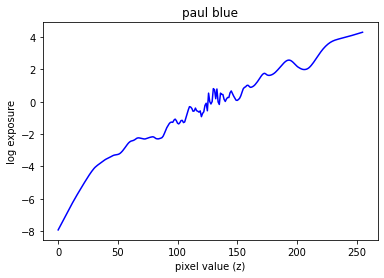

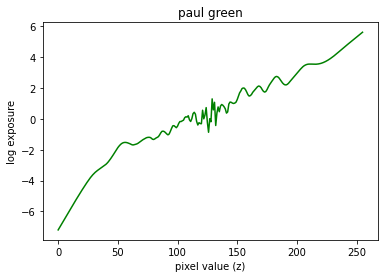

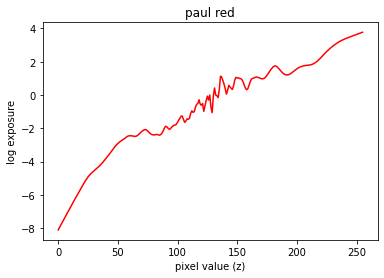

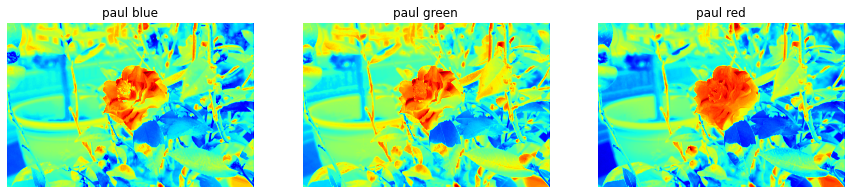

In [ ]:


def matrix_A(Z, w, lamb, constraint=127):
    N = Z[0].shape[0] # 有幾個pixel
    P = len(Z) # 有幾張照片
    A = np.zeros([N * P + 255, 256 + N])
    
    for j in range(P):
        p = Z[j]  # 第j張照片
        for i in range(N):  # ith pixel
            A[N*j + i][p[i]] = w.get_w(p[i])
            A[N*j + i][256 + i] = w.get_w(p[i])
   
    for i in range(254):
        A[N * P + i, i : i + 3] = np.array([1, -2, 1]) * np.abs(i - 127) * lamb
        
    A[-1][constraint] = 1
    return A.astype(np.float32)

def matrix_B(Z, w, expose_time_ln):
    N = Z[0].shape[0] # 有幾個pixel
    P = len(Z) # 有幾張照片
    B = np.zeros(N * P + 255)
    
    for j in range(P):
        p = Z[j]
        for i in range(N):
            B[j * N + i] = w.get_w(p[i]) * expose_time_ln[j]
    return B.astype(np.float32)

def solve_least_square(A, B):
    x = np.linalg.lstsq(A, B, rcond=None)
    x = x[0].astype(np.float32)
    return x

def find_all_color_solution(Z_bgr, w_bgr, lamda=4):
    g_list, e_list = [], []
    # find x for three color
    for z, w in zip(Z_bgr, w_bgr):
        A = matrix_A(z, w, lamda)
        B = matrix_B(z, w, expose_time_ln)
        x = solve_least_square(A, B)
        g_list.append(x[:256])
        e_list.append(x[256:])
    return g_list, e_list

g_paul, _ = find_all_color_solution(z_paul, w_bgr_paul , 15)

import matplotlib.pyplot as plt
def display_response_curves(g_list):
    col_list = ['blue', 'green', 'red']
    for i in range(3):
        g = g_list[i]
        col = col_list[i]
        col_list = ['blue', 'green', 'red']
        x = np.arange(len(g))
        plt.title("paul " + col_list[i])
        plt.xlabel("pixel value (z)")
        plt.ylabel("log exposure")
        plt.plot(x, g, color = col)
        plt.show()

display_response_curves(g_paul)

# G_bgr need to be log
def build_radiance_map_paul(images, g_paul, w_bgr):
    height,width,_ = images[0].shape
    radiance_3_paul = np.zeros([height, width, 3]).astype(np.float32)
    P = len(images)
    for c in range(3):
        w = w_bgr[c]
        w_sum = np.zeros([height, width], dtype=np.float32)
        radiance_1_sum = np.zeros([height, width], dtype=np.float32)
        for j in range(P):
            im_1D = images[j][:, :, c].flatten() # 第j張照片的第c個channel
            radiance_1_paul = (g_paul[c][im_1D] - expose_time_ln[j]).reshape(height, width)
            weight = w.get_w_array(im_1D).reshape(height, width)
            weighted_1_radiance = radiance_1_paul * weight
            radiance_1_sum += weighted_1_radiance
            w_sum += weight

        computed__1_radiance = radiance_1_sum / (w_sum + 1e-7)
        radiance_3_paul[:, :, c] = computed__1_radiance
    
    return np.exp(radiance_3_paul)
radiance_map_paul = build_radiance_map_paul(images, g_paul, w_bgr_paul)

radiance_map_paul.shape

def show_radiance_map_paul(images, radiance_map_paul, w_bgr):
    fig, axes = plt.subplots(1, 3, figsize=(15, 25))
    bgr = ['blue', 'green', 'red']
    for c in range(3):
        ax = axes[c]
        im = ax.imshow(np.log(radiance_map_paul[:,:,c]), cmap='jet')
        ax.set_title("paul " + bgr[c])
        ax.set_axis_off()
    fig.savefig('radiance_map_paul.png', bbox_inches='tight', dpi=256)
    cv2.imwrite('hdr_paul.exr', radiance_map_paul.astype(np.float32))
    return radiance_map_paul


radiance_map_paul = show_radiance_map_paul(images, radiance_map_paul, w_bgr_paul)

0 127.5 255
0 127.5 255
0 127.5 255


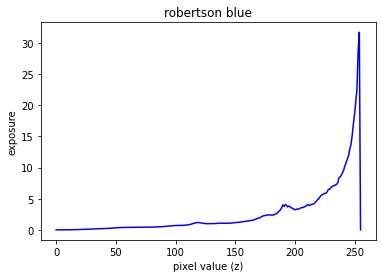

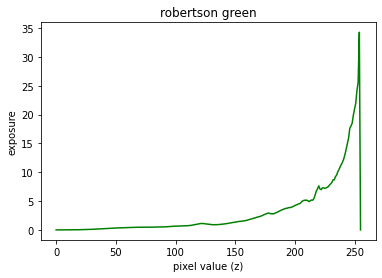

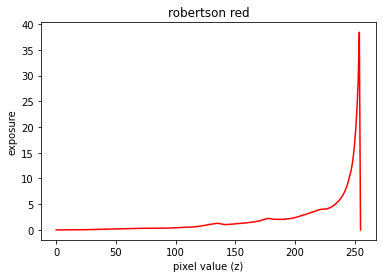

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log


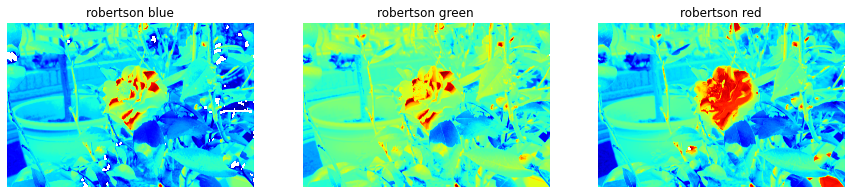

In [ ]:
def find_E(z, w, g, st):
    P = len(z)
    w_array = w.get_w_array(z).reshape(P, -1)
    g_z_array = g[z].reshape(P, -1)

    upper_sum =  np.sum(w_array * g_z_array * st, axis = 0)
    bottom_sum = np.sum(w_array * st * st, axis=0).astype(np.float32) + 1e-8

    return upper_sum /( bottom_sum + 1e-7) # shape = (N,)

def find_G(z, w, G, E, st):
    P = len(z)
    z = z.reshape(P, -1)
    w_array = w.get_w_array(z).reshape(P, -1)/128
    Wz_Em_st = w_array * (E * st)
    
    for m in range(256):
        index = np.where(z == m)
        upper = np.sum(Wz_Em_st[index]).astype(np.float32)
        lower = np.sum(w_array[index]).astype(np.float32)  + 1e-7 #避免在判斷 > 0 時有誤差
        if lower > 0:
            G[m] = upper / (lower+ 1e-7)
            
    G /= (G[127]+ 1e-7)
    return G

# initG not need to be log
def robertson_method(z_robertson, w_list, initG, epochs=2):
    g_list = []
    e_list = []
    st = expose_times.reshape(P, 1)
    for c in range(3):
        z = np.array(z_robertson[c])
        vectorG = copy.deepcopy(initG)
        vectorG = np.array(vectorG)
        w = w_list[c]
        
        for e in range(epochs):
            # Compute Ei (energy of each pixel)
            vectorE = find_E(z, w, vectorG, st)
            # Compute Gm
            vectorG = find_G(z, w, vectorG, vectorE, st)

        g_list.append(vectorG.astype(np.float32))
        e_list.append(vectorE.astype(np.float32))
        
    return g_list, e_list
w_bgr_robertson = []
for z in z_robertson:
  w = hatFunc()
  w.construct_w(np.array(z).flatten())
  w_bgr_robertson.append(w)
g_bgr_robertson, e_3_robertson = robertson_method(z_robertson, w_bgr_robertson, np.arange(0, 1, 1 / 256), epochs=5)

import matplotlib.pyplot as plt
def show_response_curves_robertson(g_list):
    col_list = ['blue', 'green', 'red']
    for i in range(3):
        LnG = g_list[i]
        col = col_list[i]
        col_list = ['blue', 'green', 'red']
        x = np.arange(len(LnG))
        plt.title("robertson " + col_list[i])
        plt.xlabel("pixel value (z)")
        plt.ylabel("exposure")
        plt.plot(x, LnG, color = col)
        plt.show()

show_response_curves_robertson(g_bgr_robertson)

ee = copy.deepcopy(e_3_robertson)

def show_radiance_robertson(images, e_3_robertson, w_bgr):
    height,width= images[0].shape[:2]
    radiance_map = np.zeros([height, width, 3]).astype(np.float32)
    for c in range(3):
        e_3_robertson[c] = e_3_robertson[c].reshape(height, width)
    radiance_map = np.zeros([height, width, 3]).astype(np.float32)
    for c in range(3):
        for w in range(width):
            for h in range(height):
                radiance_map[h, w, c] = e_3_robertson[c][h, w]
    fig, axes = plt.subplots(1, 3, figsize=(15, 25))
    bgr = ['blue', 'green', 'red']

    for c in range(3):
        ax = axes[c]
        im = ax.imshow(np.log(e_3_robertson[c]), cmap='jet')
        ax.set_title("robertson " + bgr[c])
        ax.set_axis_off()
    fig.savefig('radiance_map_robertson.png', bbox_inches='tight', dpi=256)
    cv2.imwrite('hdr_robertson.exr', radiance_map.astype(np.float32))
    return radiance_map

e_3_robertson = copy.deepcopy(ee)
radiance_map_robertson = show_radiance_robertson(images, e_3_robertson, w_bgr_robertson)

In [ ]:


def photographic_global(radiance,d=1e-6,a=0.01):
  Lw=np.exp(np.mean(np.log(d+radiance)))
  Lm=(a/Lw)*radiance
  Lm_max=np.max(Lm)
  Ld=(Lm*(1+(Lm/Lm_max**2)))/(1+Lm)
  return np.clip(np.array(Ld * 255), 0, 255).astype(np.uint8)

from google.colab.patches import cv2_imshow
res = photographic_global(radiance_map_paul, a=0.1)
cv2_imshow(res)

res = photographic_global(radiance_map_robertson, a = 0.3)
cv2_imshow(res)
cv2.imwrite('global_robertson.jpg', radiance_map_robertson.astype(np.float32))
res = photographic_global(radiance_map_paul, a = 0.05)
cv2_imshow(res)
cv2.imwrite('global_paul.jpg', radiance_map_paul.astype(np.float32))

def photographic_local(radiance,a,phi=8,smax=25,epsilon=0.01):
  Lm_max=np.max(radiance)
  i_range=int((smax+1)/2)
  prev_blur=radiance
  L_blur_list = np.zeros(radiance.shape + (i_range+1,))
  L_blur_list[:,:,0]=radiance
  
  Vs_list = np.zeros(radiance.shape)
  for i in range(i_range):
    s=i*2+1
    L_blur=cv2.GaussianBlur(radiance,(s,s),0)
    Vs=np.abs(L_blur-radiance)/(2**phi*(a/(s**2))+L_blur)
    L_blur_list[:,:,i+1]=L_blur
    Vs_list[np.where(Vs < epsilon)]=i
    prev_blur=L_blur
  int_blur=Vs_list.astype(int)
  cols,rows=radiance.shape
  I, J = np.ogrid[:cols, :rows,]
  blur_result = L_blur_list[I, J,int_blur]
  return blur_result
def photographic(radiance,a):
  #local operator
  local_result=np.zeros(radiance.shape)
  for c in range(3):
    Lw=np.exp(np.mean(np.log(1e-6+radiance)))
    Lm=(a*radiance)/Lw 
    
    local_result_tmp = photographic_local(Lm[:,:,c],a)
    Ld = Lm[:,:,c]/(1+local_result_tmp)
    Ld = np.clip(np.array(Ld * 255), 0, 255).astype(np.uint8)
    local_result[:,:,c] = Ld
    #local_result[:,:,c]=np.clip(np.array(photographic_local(Lm[:,:,c]) * 255), 0, 255).astype(np.uint8)
  return local_result

# print local tone Mapping result
res = photographic(radiance_map_robertson,a =0.25)
cv2_imshow(res)
cv2.imwrite('local_robertson.jpg', radiance_map_robertson.astype(np.float32))
res = photographic(radiance_map_paul,a=0.05)
cv2_imshow(res)
cv2.imwrite('local_paul.jpg', radiance_map_paul.astype(np.float32))